# Pad for UR PSSM Representation

In [8]:
from Bio import motifs, SeqIO
from Bio.Seq import Seq

def compute_pssm(lseq, pscount={'A':0.25,'C':0.25,'G':0.25,'T':0.25}, \
                 background={'A':0.25,'C':0.25,'G':0.25,'T':0.25}):
    '''Comptes the PFM, PWM, and PSSM of a list of nucleotide sequences'''
    # a Biopython motif object
    m = motifs.create(list(map(Seq, lseq)))

    pfm = m.counts
    # pwm with no pscount is a stochastic matrix
    pwm = m.counts.normalize(pseudocounts=pscount)
    #pwm = m.pwm
    pssm = pwm.log_odds(background)
    return pfm, pwm, pssm, m, m.consensus

# ===============================================================================
logo_file = 'temp_logo.png'
# =================================================================================
lseq = ['AGCT', 'ACGT', 'GTCG', 'ATTG', 'TGCG', 'CCGT']
background = {"A":0.6, "C": 0.4, "G": 0.4, "T": 0.6}
pfm, pwm, pssm, m, cons = compute_pssm(lseq, background=background, pscount=background)

#pfm, pwm, pssm, m = compute_pssm(lseq, {"A":0.6, "C": 0.4, "G": 0.4, "T": 0.6}, {"A":0.6, "C": 0.4, "G": 0.4, "T": 0.6})
print(pfm)
print(pfm[0:3,0:4])
print(pwm)
print(pssm)
print('consensus: {}'.format(cons))
print('mean = {:2.4f}, std = {:2.4f}'.format(pssm.mean(background),pssm.std(background)))
print('Instances are:\n{}'.format(list(m.instances)))

# creating a logo
#m.weblogo(logo_file)




        0      1      2      3
A:   3.00   0.00   0.00   0.00
C:   1.00   2.00   3.00   0.00
G:   1.00   2.00   2.00   3.00
T:   1.00   2.00   1.00   3.00

{'A': [3, 0, 0, 0], 'C': [1, 2, 3, 0], 'G': [1, 2, 2, 3]}
        0      1      2      3
A:   0.45   0.07   0.07   0.07
C:   0.17   0.30   0.42   0.05
G:   0.17   0.30   0.30   0.42
T:   0.20   0.33   0.20   0.45

        0      1      2      3
A:   0.58  -2.00  -2.00  -2.00
C:  -0.19   0.58   1.09  -2.00
G:  -0.19   0.58   0.58   1.09
T:  -0.58   0.12  -0.58   0.58

consensus: AGCG
mean = 1.1634, std = 1.5649
Instances are:
[Seq('AGCT'), Seq('ACGT'), Seq('GTCG'), Seq('ATTG'), Seq('TGCG'), Seq('CCGT')]


## Information Content Functions

In [16]:
import numpy as np
import math

# code is based on:
# https://github.com/saketkc/motif-logos-matplotlib/blob/master/Sequence%20logos%20in%20Python.ipynb
# However, the code there has few errors. The code below follows the paper "Information Content
# of Binding Sites of Nucleotide Sequences"

def calc_IC_approx_err(motif):
    '''Approximate calculate of small-sample correction error'''
    bases = list(motif.pwm.keys())
    n = len(motif.counts[bases[0]])  # sequence length 
    return (len(bases)-1)/(2 * np.log(2) * n)


def calc_IC_exact_err(motif):
    '''Exact computation of small-sample correction error'''
    ##  O(n^3)
    print('Computing exact correction error...')
    pwm = motif.pwm
    bases = list(pwm.keys())
    na = len(motif.counts['A'])  # sequence length 
    n = na
    nc = 0
    ng = 0
    nt = 0
    done = False
    exact_error = 0
    while not done:
        #print (na,nc,ng,nt)
        pp = (0.25**na)*(0.25**nc)*(0.25**ng)*(0.25**nt)
        frac = pp*math.factorial(na+nc+ng+nt)/(math.factorial(na)*math.factorial(nc)*\
                                               math.factorial(ng)*math.factorial(nt))
        exact_error += frac*sum([-p*np.nan_to_num(np.log2(p)) for p in \
                                 [na/n, nc/n, ng/n, nt/n]])
        if nt<=0:
            ## iterate inner loop            
            if ng > 0:
                ## g => t
                ng = ng - 1
                nt = nt + 1
            elif nc > 0:
                ## c -> g 
                nc = nc - 1;
                ng = ng + 1;
            else:
                ## a->c
                na = na - 1
                nc = nc + 1
        else:
            if ng > 0:
                ## g => t
                ng = ng - 1 
                nt = nt + 1
            elif nc>0:
                ## c => g; all t -> g
                nc = nc - 1
                ng = nt + 1
                nt = 0
            elif na>0:
                ## a => c; all g,t -> c
                nc = nt + 1
                na = na - 1
                nt = 0
            else:
                done = True
    return exact_error


def calc_info_content(motif, corr_type = 'no'):
    '''Calculate information content with small sample correction.
    Note that for both corr_type=='approx' (should be used for
    sequences larger than 50 nt) and for corr_type=='exact' (should
    be used for sequences smaller than 50 nt), the output can attain
    both negative and positive values. See the paper "Information Content
    of Binding Sites of Nucleotide Sequences". Thus, for sequence logos, use
    the default (i.e. corr_type = 'no)
    '''
    pwm = motif.pwm  # should not use relative information
    bases = list(pwm.keys())
    if corr_type=='no':
        Hg = np.log2(len(bases))
    elif corr_type=='approx':
        Hg = np.log2(len(bases)) - calc_IC_approx_err(motif)
    else:  # exact 
        Hg = calc_IC_exact_err(motif)
    #print('Hg = {}'.format(Hg))
    return [Hg+sum([pwm[b][l]*np.nan_to_num(np.log2(pwm[b][l])) for b in bases])\
            for l in range(0, len(motif))]

def calc_rel_info(motif, corr_type = 'no'):
    '''Calculate relative information'''
    info_cont = calc_info_content(motif, corr_type)
    return {b: [np.nan_to_num(p*i) for p, i in zip(motif.pwm[b], info_cont)] \
            for b in list(pwm.keys())}


# PSSM of URs

In [4]:
import pandas as pd
import os
import numpy as np
from Bio import motifs, SeqIO
from Bio.Seq import Seq
import re
from collections import deque
from termcolor import colored

def get_other_UR_URs(other_UR_cell, mlen=3):
    '''Returns the list of URs in a cell of the column other_UR'''
    return re.findall('[ACGT]{'+str(mlen)+'}', other_UR_cell)

def get_other_UR_percs(other_UR_cell):
    '''Returns the list of percentages of a cell of the column other_UR'''
    return list(map(float, re.findall(r'(\d+\.\d*)\%', tmp_other)))
# =================================================================================
mlen = 3
logo_file = 'temp_logo.png'
# =================================================================================
UR_xlsx_file = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/top_UR_m'\
+str(mlen)+'.xlsx'

dtype = {'vgrp_type':str, 'vgrp_name':str, 'top_UR':str, 'perc_in_grp':str, 'other_UR':str}
df = pd.read_excel(UR_xlsx_file, header=0, dtype=dtype)
#print(df.head())
#print(df.info())
#print(type(df))
#print(list(df.columns))

columns_names = list(df.columns)
print('Found {} columns:'.format(len(columns_names)))
for i, s in enumerate(columns_names): print(i,s,sep='. ')

all_vgrp_type = df.loc[:][columns_names[0]]
all_vgrp_name = df.loc[:]['vgrp_name']
all_top_UR = df.loc[:]['top_UR']
all_other_UR = df.loc[:]['other_UR']
all_perc_in_grp = df.loc[:]['perc_in_grp']


# a simple test
row = 178
tmp_other = all_other_UR[row]
if tmp_other!='nan':
    tmp_URs = deque(re.findall('[ACGT]{3}', tmp_other))  # the other URs
    tmp_perc = deque((map(float, re.findall('(\d+\.\d+)\%', tmp_other))))  # their corresponding percentage

    # append the top UR and its percentage
    #tmp_URs.insert(0, all_top_UR[row])
    #tmp_perc.insert(0, all_perc_in_grp[row][:-1]) # remove the % sign at the end
    tmp_URs.appendleft(all_top_UR[row])
    tmp_perc.appendleft(all_perc_in_grp[row][:-1])
    #print(tmp_perc)
    #print(*list(tmp_URs))
    pfm, pwm, pssm, m, cons = compute_pssm(list(tmp_URs))
    print('PSSM info for row {}:'.format(row))
    print(pfm, pwm, pssm, sep='\n')

# Testing PSSM for first few rows
max_rows = 30;
thres=3
print(colored('\nTesting {} rows fron excel file:', 'blue').format(max_rows))
for r in range(0,max_rows):
    print(colored('{r}.\t{grp_name}:','red').format(r=r, grp_name=all_vgrp_name[r]))
    #URs = [all_top_UR[r]]
    URs = deque([all_top_UR[r]])
    if URs[0]!='nan':
        weight = deque([float(all_perc_in_grp[r][:-1])/100])
        tmp_other = all_other_UR[r]
        if tmp_other!='nan':
            #URs.extend(get_other_UR_URs(tmp_other))
            #weight.extend(list(map(lambda x:x/100.0, get_other_UR_percs(tmp_other))))
            URs.extend(get_other_UR_URs(tmp_other,mlen))
            weight.extend((map(lambda x:x/100.0, get_other_UR_percs(tmp_other))))
            pfm, pwm, pssm, m, cons = compute_pssm(URs)
        print('{URs} : {weight}'.format(URs=list(URs), weight=list(weight)))
        if len(URs)>=thres: print(pfm, pssm, sep='\n')


Found 6 columns:
0. vgrp_type
1. vgrp_name
2. vgrp_size
3. top_UR
4. perc_in_grp
5. other_UR
PSSM info for row 178:
        0      1      2
A:   1.00   3.00   1.00
C:   1.00   0.00   4.00
G:   3.00   1.00   0.00
T:   1.00   2.00   1.00

        0      1      2
A:   0.18   0.46   0.18
C:   0.18   0.04   0.61
G:   0.46   0.18   0.04
T:   0.18   0.32   0.18

        0      1      2
A:  -0.49   0.89  -0.49
C:  -0.49  -2.81   1.28
G:   0.89  -0.49  -2.81
T:  -0.49   0.36  -0.49


Testing 30 rows fron excel file:
0.	Avsunviroidae:
1.	Bacteria:
['GTA', 'CCC', 'CGC', 'CTC', 'GGG', 'AAT'] : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        0      1      2
A:   1.00   1.00   1.00
C:   3.00   1.00   3.00
G:   2.00   2.00   1.00
T:   0.00   2.00   1.00

        0      1      2
A:  -0.49  -0.49  -0.49
C:   0.89  -0.49   0.89
G:   0.36   0.36  -0.49
T:  -2.81   0.36  -0.49

2.	Deltavirus:
3.	Pospiviroidae:
4.	Retro-transcribing:
5.	Satellites:
6.	Virus:
['GGG', 'AGA', 'CGA', 'CCC', 'TCC'] : [0.8, 0.2, 0.2, 0.2

# Testing UR_rnd_m<val>_<spec>

In [20]:
from pprint import pprint

mlen = 3
spec = 'dsDNA_Bacteria'
top_num = 12 #9
seq_logo_file = 'seq_file.png'
# ========================================================================================
dtype_rnd = {'signf_sorted':str, 'tot_num_Fall_sort':int}
UR_rnd_xlsx_file = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_rnd_m'\
+str(mlen)+'_'+spec+'.xlsx'

df_rnd = pd.read_excel(UR_rnd_xlsx_file, header=0, dtype=dtype_rnd)

columns_names = list(df_rnd.columns)
# print('Found {} columns:'.format(len(columns_names)))
# for i, s in enumerate(columns_names, 1): print(i,s,sep='. ')



top_UR = {df_rnd.loc[s][columns_names[0]] : df_rnd.loc[s][columns_names[1]] for s in range(top_num)}
eql_nt = {s for s in top_UR.keys() if len(set(s))==1}
diff_nt = set(top_UR.keys()) - eql_nt


print('eql:', eql_nt)
print('diff:', diff_nt )

backg={'A':0.25,'C':0.25,'G':0.25,'T':0.25}
pfm, pwm, pssm, m, cons = compute_pssm(diff_nt, backg, backg)
print(pfm, pwm, pssm, sep='\n')

print('Update PWM!!')
pwm = m.pwm
bases = list(pwm.keys())

q = [sum([pwm[b][l]*np.nan_to_num(np.log2(pwm[b][l])) for b in bases]) for l in range(0, len(m))]
print(pwm, q, sep='\n')

# testing sequence logo values
#print('Approx Hg = ', calc_IC_approx_err(m, 'approx'), ' (2-Hg)=', 2-calc_en_err(m, 'approx'))
#print('Exact Hg = ', calc_info_content(m,'exact'))

print('Approx: ', calc_info_content(m,'approx'))
print('Exact: ', calc_info_content(m,'exact'))
print('No: ', calc_info_content(m,'no'))

info_cont = calc_info_content(m)
print('\ninfo_cont = ', info_cont)
print(m.pwm['A'])

#pprint(calc_rel_info(m, 'exact'))

#bases = list(m.pwm.keys())
#print(len(m.counts[bases[1]]))
#print(list(pwm.keys()))
#print(len(m.counts[0]))
#print(np.log2(len(list(pwm.keys()))))
#print(pwm['A'][3])
#print(len(m))
#print(list(pwm.keys()))
#print(m.counts["A"])
# creating a logo
#m.weblogo(seq_logo_file, format='png', version='3.3', kwds={'stack_width' : 'large'} )





eql: {'AAA', 'CCC', 'GGG', 'TTT'}
diff: {'GAG', 'TGT', 'TAG', 'CGA', 'GAC', 'CTC', 'CGC', 'GGA'}
        0      1      2
A:   0.00   3.00   2.00
C:   3.00   0.00   3.00
G:   3.00   4.00   2.00
T:   2.00   1.00   1.00

        0      1      2
A:   0.03   0.36   0.25
C:   0.36   0.03   0.36
G:   0.36   0.47   0.25
T:   0.25   0.14   0.14

        0      1      2
A:  -3.17   0.53   0.00
C:   0.53  -3.17   0.53
G:   0.53   0.92   0.00
T:   0.00  -0.85  -0.85

Update PWM!!
        0      1      2
A:   0.00   0.38   0.25
C:   0.38   0.00   0.38
G:   0.38   0.50   0.25
T:   0.25   0.12   0.12

[-1.561278124459133, -1.4056390622295665, -1.9056390622295665]
Approx:  [-0.28262564490361486, -0.1269865826740484, -0.6269865826740484]
Computing exact correction error...
Exact:  [-0.4503757800330488, -0.2947367178034823, -0.7947367178034823]
No:  [0.43872187554086706, 0.5943609377704335, 0.09436093777043353]

info_cont =  [0.43872187554086706, 0.5943609377704335, 0.09436093777043353]
(0.0, 0.375, 0.2

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log2
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log2
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log2


# Plot sequence Logo

In [ ]:
import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import transforms
import matplotlib.patheffects
import matplotlib.pyplot as plt


COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}
motif = m
# ==============================
bases = list(COLOR_SCHEME.keys())
class Scale(matplotlib.patheffects.RendererBase):
    def __init__(self, sx, sy=None):
        self._sx = sx
        self._sy = sy

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        affine = affine.identity().scale(self._sx, self._sy)+affine
        renderer.draw_path(gc, tpath, affine, rgbFace)

rel_info = calc_rel_info(motif, 'no') # for sequence logo plot, use with no correction
#pprint(rel_info)

fig = plt.figure()
fig.set_size_inches(len(motif),2.5)
ax = fig.add_subplot(111)
ax.set_xticks(range(len(motif)))

xshift = 0
xticks_t = []
xshifts = [xshift]
trans_offset = transforms.offset_copy(ax.transAxes, 
                                  fig=fig, 
                                  x=0, 
                                  y=0, 
                                  units='points')

#inv = ax.transData.inverted()
#xticks_t.append(inv.transform_point((xshift,0))[0])

for i in range(0, len(motif)):
    scores = [(b,rel_info[b][i]) for b in bases]
    scores.sort(key=lambda t: t[1])
    yshift = 0
    for base, score in scores:
        txt = ax.text(0, 
                      0, 
                      base, 
                      transform=trans_offset,
                      fontsize=80, 
                      color=COLOR_SCHEME[base],
                      weight='bold',
                      ha='center',
                      family='sans-serif'
                      )
        txt.set_clip_on(False) 
        txt.set_path_effects([Scale(1.0, score)])
        fig.canvas.draw()
        window_ext = txt.get_window_extent(txt._renderer)
        yshift = window_ext.height*score
        trans_offset = transforms.offset_copy(txt._transform, fig=fig, y=yshift, units='points')
    xshift += window_ext.width
    xshifts.append(xshift)
    inv = ax.transData.inverted()

    trans_offset = transforms.offset_copy(ax.transAxes, fig=fig, x=xshift, units='points')
    xticks_t.append(inv.transform_affine((xshift*2.4, 0))[0])


ax.set_yticks(range(0,3))


seaborn.despine(ax=ax, offset=30, trim=True)
ax.set_xticklabels(range(1,len(motif)+1), rotation=90)
ax.set_yticklabels(np.arange(0,3,1))
plt.show()





# Another try to plot seqlogo

In [ ]:
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties

fp = FontProperties(family="Arial", weight="bold") 
#fp = FontProperties(family="sans-serif", weight="bold") 

globscale = 1.35  # this, and the values here below were set for family="Arial"
LETTERS = { "T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
            "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
            "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
            "C" : TextPath((-0.366, 0), "C", size=1, prop=fp) }

COLOR_SCHEME = {'G': 'orange', 
                'A': 'red', 
                'C': 'blue', 
                'T': 'darkgreen'}

def letterAt(letter, x, y, yscale=1, ax=None):
    '''Plots a letter at a given position with a given scale.'''
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

# Up to here can be a module
# =======================================================================================

# now the actual code
import matplotlib.pyplot as plt

motif = m
rel_info = calc_rel_info(motif, 'no')
save_fig_file = '' #'fig_logo.png'
# =============================================
fig, ax = plt.subplots(figsize=(5,2))
x = 1
maxi = 0
for i in range(0, len(motif)):
    scores = [(b,rel_info[b][i]) for b in bases]
    scores.sort(key=lambda t: t[1])
    y = 0
    for base, score in scores:
        letterAt(base, x, y, score, ax)
        y += score
    x += 1
    maxi = max(maxi, y)
plt.xticks(range(1,x))
plt.xlim((0, x)) 
plt.ylim((0, maxi)) 
ax.set_ylabel('Bits')
plt.tight_layout()      
#plt.show()
if save_fig_file!='': plt.savefig(save_fig_file, dpi=200)
    
print(len(motif))
print(len(list(rel_info.values())[0]))


# Sequence Logo function

In [13]:
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

def gen_nt_sequence_logo(rel_info, fig_size=(5,2)):
    '''Generates nucleotide sequence logo.
    rel_info is computed by: rel_info=calc_rel_info(motif, 'no')'''
    fp = FontProperties(family="Arial", weight="bold") 
    globscale = 1.35  # this, and the values here below were set for family="Arial"
    LETTERS = { 'T' : TextPath((-0.305, 0), "T", size=1, prop=fp),
                'G' : TextPath((-0.384, 0), "G", size=1, prop=fp),
                'A' : TextPath((-0.35, 0), "A", size=1, prop=fp),
                'C' : TextPath((-0.366, 0), "C", size=1, prop=fp) }

    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen'}

    def letterAt(letter, x, y, yscale=1, ax=None):
        '''Plots a letter at a given position with a given scale.'''
        text = LETTERS[letter]

        t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
            mpl.transforms.Affine2D().translate(x,y) + ax.transData
        p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter], transform=t)
        if ax != None:
            ax.add_artist(p)
        return p
    
    fig, ax = plt.subplots(figsize=fig_size)
    x = 1
    maxi = 0
    for i in range(0, len(list(rel_info.values())[0])):
        scores = [(b,rel_info[b][i]) for b in COLOR_SCHEME.keys()]
        scores.sort(key=lambda t: t[1])
        y = 0
        for base, score in scores:
            letterAt(base, x, y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)
    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    
    return fig, ax

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log2


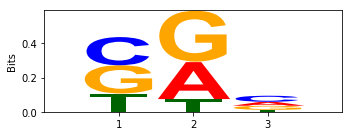

In [21]:
# testing the function above

logo_fname = 'tmp_logo.png'


rel_info = calc_rel_info(m, 'no') # make sure the cells above are executed
fig, ax = gen_nt_sequence_logo(rel_info)
ax.set_ylabel('Bits')
plt.tight_layout()      
if logo_fname!='': plt.savefig(logo_fname, dpi=200)

# Test itertools

In [26]:
import itertools as it

x = it.count(1)
y = next(x)
z = next(x)
print(x, y, z)

count(3) 1 2
